### Computational Holography

Before even connecting an SLM, `slmsuite`'s modular iterative holography algorithms, GPU acceleration, and ... suite ... of useful toolboxes make it a powerful tool for computational holography education, exploration, and research.   

In this first tutorial, we'll walk through the basic functionality. Specifically, we will:

- Make and visualize various target far-field patterns (spot arrays)
- Solve for the associated near-field phase masks using iterative Fourier transform (e.g. Gerchberg-Saxton or "GS") algorithms 
- Compare convergence and pattern uniformity with various flavors of GS
- Generalize these principles from spot arrays to images

We'll start by importing `slmsuite` and a few packages. Note that `slmsuite` will automatically import [`cupy`](https://cupy.dev/) for GPU acceleration if it's installed; otherwise, `numpy` will be used for (much slower) internal computation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add slmsuite to the python path.
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('image', cmap='Blues')

#### SLM Fundamentals

The simplest setup for a phase-type (e.g. LCOS) SLM places the device one focal length ($f$) in front of a thin lens to produce a desired image or pattern in the conjugate focal plane (i.e. a distance $f$ behind the lens). In this common configuration, the SLM and "image plane" are ideally related by the Fourier transform. We can therefore use `slmsuite`'s phase retrieval algorithms to solve for the unknown near-field phase pattern (that we'll eventually apply to our SLM in an experiment) that reproduces the desired far-field target in the imaging plane. Let's try it out with a simple far-field target pattern: a single pixel illuminated on a $32 \times 32$ pixel grid.

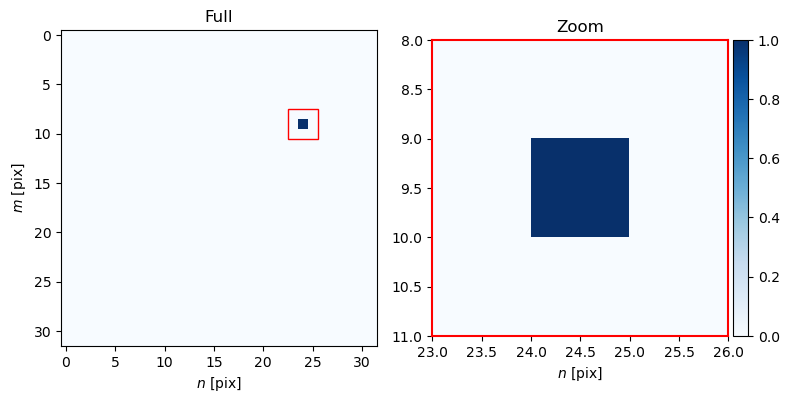

In [2]:
# Import phase retrieval algorithms
from slmsuite.holography.algorithms import Hologram

# Make the desired image: a random pixel targeted in a 32x32 grid
target_size = (32,32)
target = np.zeros(target_size)
target[9,24] = 1

# Initialize the hologram and plot the target
# Note: For now, we'll assume the SLM and target are the same size (since they're a Fourier pair)
slm_size = target_size
hologram = Hologram(target,slm_shape=slm_size)
zoombox = hologram.plot_farfield(source=hologram.target, cbar=True)

In this case, we plotted the target in the basis ``"knm"`` representing the pixel indices of the SLM's computational $k$-space (here, ``"knm"`` is aligned with the far-field camera's pixels -- the ``"ij"`` basis -- so the two are synonymous). However, since this plane and the SLM plane are a Fourier pair, each target pixel corresponds to a 2D spatial frequency applied in the SLM plane. The exact unit conversion requires some physical properties of the SLM and camera (i.e. the detector in imaging the target). To illustrate this point, we'll instantiate simulated objects of the SLM and camera classes.

For our computations, these objects are just useful ways to store the simulated SLM and camera properties. In a real experiment, their methods will also control the hardware. 

We'll also instatiate a setup object (of the ``CameraSLM`` class) to store both the camera and SLM. In an actual experiment, the ``CameraSLM`` methods help find the relative orientation between the two devices (and more..).  

In [3]:
#Create a virtual SLM and camera
from slmsuite.hardware.slms.slm import SLM
from slmsuite.hardware.cameras.camera import Camera
from slmsuite.hardware.cameraslms import FourierSLM

# Assume a 532 nm laser
wav_um = 0.532
slm = SLM(slm_size[0], slm_size[1], dx_um=10, dy_um=10, wav_um=wav_um)
camera = Camera(target_size[0], target_size[1])

# The setup (a FourierSLM setup with a camera placed in the Fourier plane of an SLM) holds the camera and SLM. 
setup = FourierSLM(camera, slm)
hologram.cameraslm = setup

santec.py: Santec DLLs not installed. Install these to use Santec SLMs.
  Dynamically linked libraries from Santec (usually provided via USB) must be present in the slms directory:
  - SLMFunc.dll
  - FTD3XX.dll
  You can find the slms directory at 'C:\Users\cpanu\Documents\GitHub\slmsuite\slmsuite\hardware\slms'
  Check that theses files are present and are error-free.
Original error: Could not find module 'SLMFunc.dll' (or one of its dependencies). Try using the full path with constructor syntax.
screenmirrored.py: pyglet not installed. Install to use ScreenMirrored SLMs.
alliedvision.py: vimba not installed. Install to use AlliedVision cameras.
filr.py: PySpin not installed. Install to use FLIR cameras.
mmcore.py: pymmcore not installed. Install to use Micro-Manager cameras.
thorlabs.py: thorlabs_tsi_sdk DLL not found. Resolve to use Thorlabs cameras.
thorlabs.py: thorlabs_tsi_sdk not installed. Install to use Thorlabs cameras.


With these objects created, we can now re-plot the target image plane in various spatial frequency units. See the ``slmsuite.holography.toolbox.convert_blaze_vector`` function documentation for definitions of these units. 

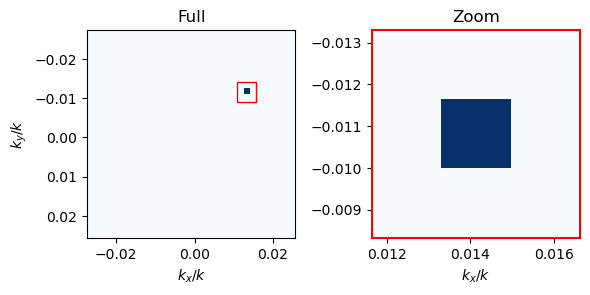

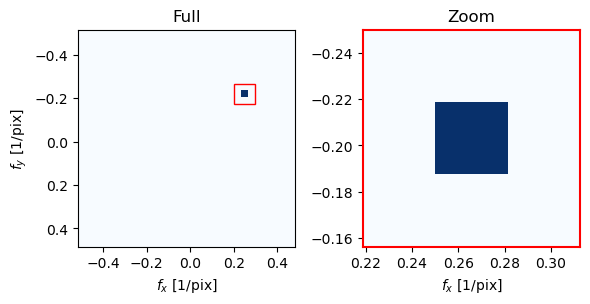

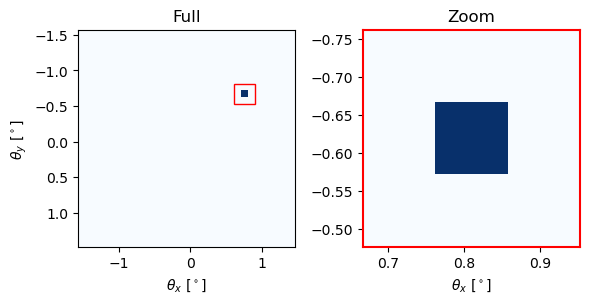

In [4]:
# Not all inclusive, but try out a few units
for units in ["kxy", "freq", "deg"]:
    hologram.plot_farfield(source=hologram.target, units=units, figsize=(6,3))

With a solid understanding of the near- and far-field characteristics, we can now move onto actually solving for the near-field phase mask. We'll start with the classic [Gerchberg-Saxton iterative Fourier transform algorithm](https://en.wikipedia.org/wiki/Gerchberg%E2%80%93Saxton_algorithm).

Optimizing with GS using the following flags:
{'feedback': '', 'fixed_phase': False, 'stat_groups': []}


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 133.24it/s]


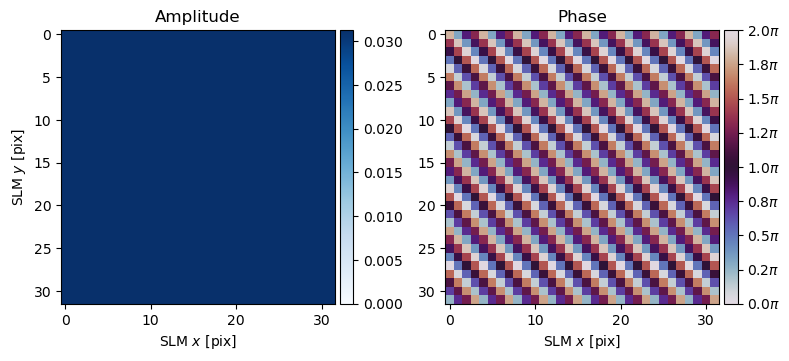

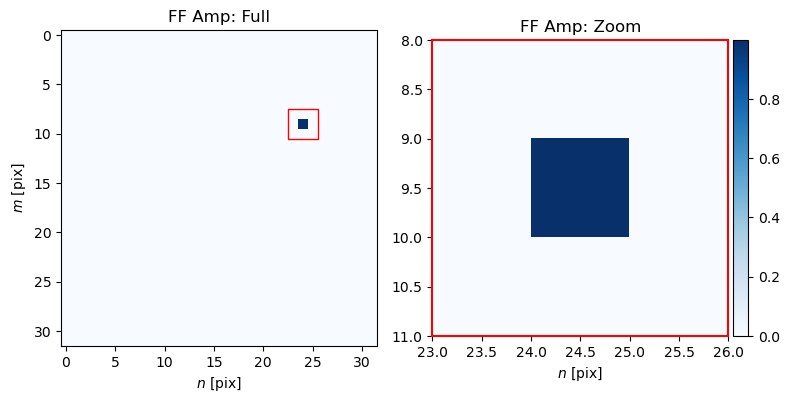

In [5]:
# Run 5 iterations of GS. 
hologram.optimize(method='GS', maxiter=5)

# Look at the associated near- and far- fields
hologram.plot_nearfield(cbar=True)
hologram.plot_farfield(source=hologram.amp_ff, limits=zoombox, cbar=True, title='FF Amp');

The near-field amplitude is unity (the SLM class assumes uniform illumination by default) and GS calculated a beautiful diagonal grating (with a ~4 pixel horizontal/vertical period as expected from the unit conversion plots above.

While at first glance it looks like the GS-computed phase mask *exactly* reproduces the desired far-field target pattern, this is actually not the case. From basic Fourier theory, we know that a uniformly illuminated aperture (comprising $N$ pixels of length $\Delta$ will emit a beamwidth $\delta k/2\pi \approx 1/N\Delta$. Sampling in increments of $\Delta$ in the near-field also corresponds to a total spatial frequency range of $1/\Delta$, which yields a bin width $1/N\Delta$ for $N$ pixels. So it only appears that we created the perfect target pattern because each pixel in the far-field corresponds to a diffraction-limited spot. 

To see the true pattern, we can increase the far-field resolution by zero-padding the near-field.

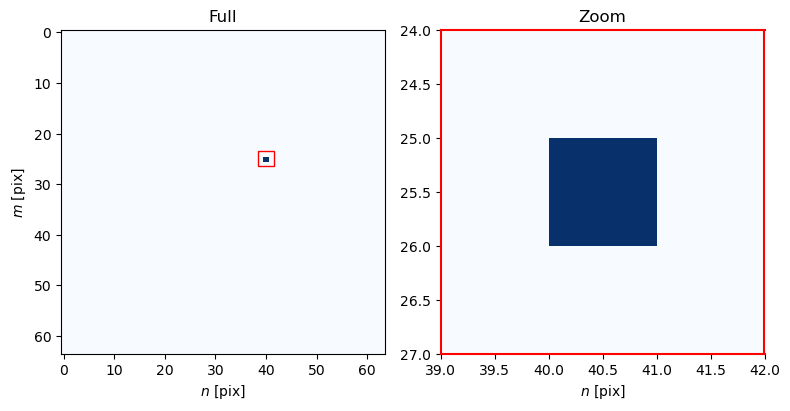

Optimizing with GS using the following flags:
{'feedback': '', 'fixed_phase': False, 'stat_groups': []}


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 285.34it/s]


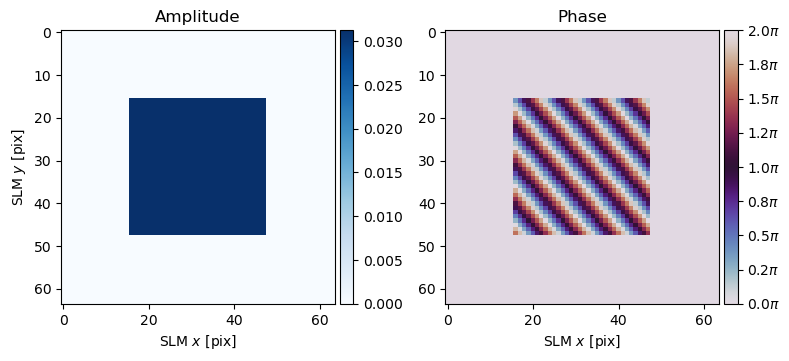

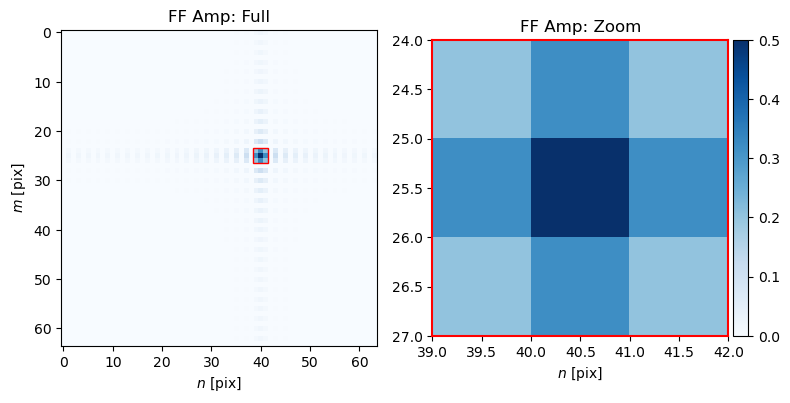

In [6]:
from slmsuite.holography import toolbox

# Get the padding needed to resolve 2x smaller than a diffraction limited spot
hologram.shape = hologram.calculate_padded_shape(setup, precision=0.5/(slm.dx*slm.shape[0]))
target_padded = toolbox.pad(target, hologram.shape)

# Recompute the far-field
hologram = Hologram(target_padded, slm_shape=slm.shape)
zoombox_padded = hologram.plot_farfield(target_padded)
hologram.optimize(method='GS', maxiter=5) 

# Look at the associated near- and far- fields
hologram.plot_nearfield(padded=True, cbar=True)
hologram.plot_farfield(source=hologram.amp_ff, cbar=True, units="deg", 
                       title='FF Amp', limits=zoombox_padded);

Likewise, far-field pixels are also smaller than diffraction limited spots when the near-field amplitude doesn't fully fill the SLM aperture as illustrated below.

Optimizing with GS using the following flags:
{'feedback': '', 'fixed_phase': False, 'stat_groups': []}


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.39it/s]


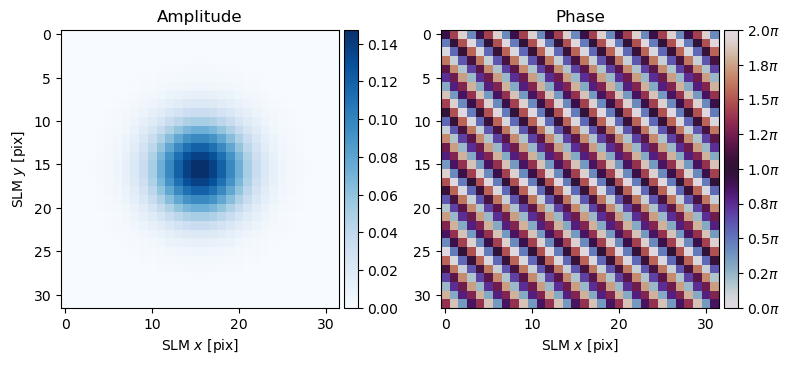

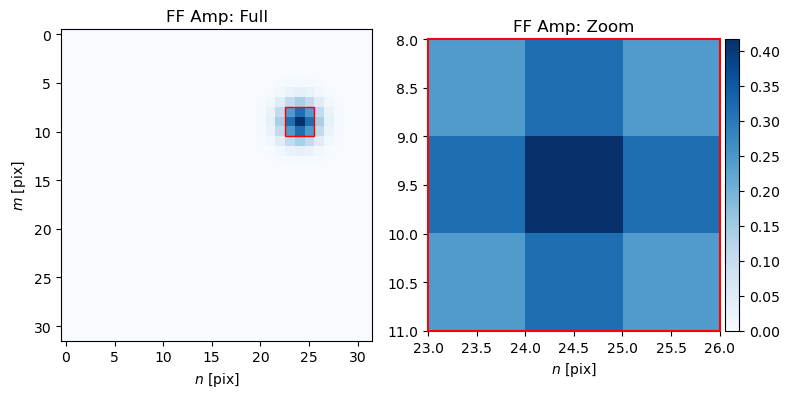

In [7]:
# Set a Gaussian amplitude profile on SLM with radius = 100 in units of x/lam
slm.set_measured_amplitude_analytic(100) 

# Redo the same GS calculations
hologram = Hologram(target, slm_shape=slm.shape, amp=slm.measured_amplitude)
hologram.optimize(method='GS', maxiter=5) 

hologram.plot_nearfield(padded=True,cbar=True)
hologram.plot_farfield(cbar=True,limits=zoombox);

#### Spot Arrays

Now that we've discussed bare-bones GS algorithms, SLM setups, and Fourier principles, we can move onto more realistic targets. Here, for example, we'll start looking at many spots in the target plane vs a single one. These patterns may seem simple but are actually an enabling tool for state-of-the-art [quantum computing](https://www.nature.com/articles/s41586-021-03582-4) (where arrays of optical tweezers -- the topic of the [2018 Nobel Prize in Physics](https://www.aps.org/publications/apsnews/201811/nobel18.cfm) -- trap and excite atom arrays), [optogenetics](https://www.nature.com/articles/s41593-021-00902-9) (where desired neurons are dynamically excited), and [laser printing](https://www.nature.com/articles/s41377-019-0215-1).

Let's give it a shot with ``SpotHologram``, a wrapper of the ``Hologram`` "super-class" with various utilities for making and characterizing spot arrays.

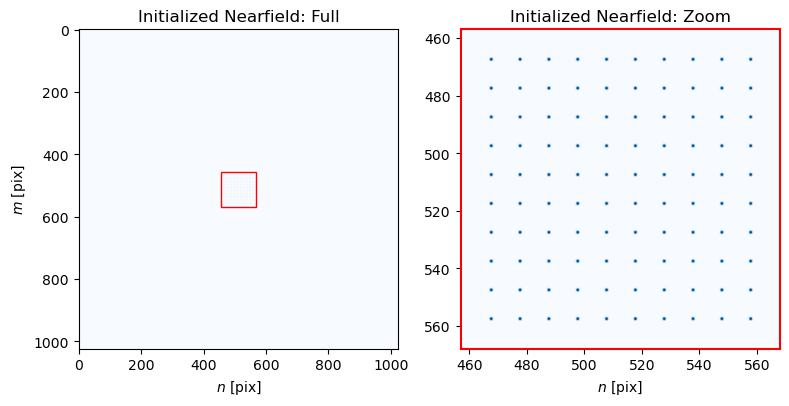

In [8]:
from slmsuite.holography.algorithms import SpotHologram

# Move to a larger grid size
slm_size = (1024, 1024)

# Instead of picking a few points, make a rectangular grid in the knm basis
array_holo = SpotHologram.make_rectangular_array(slm_size,
    array_shape=(10,10), array_pitch=(10,10), basis='knm')
zoom = array_holo.plot_farfield(source=array_holo.target, title='Initialized Nearfield')

Now we'll run the optimization to produce our intended target: a far-field array of optical foci with uniform amplitude). For ease, the ``optimize`` method uses a parameter naming convention borrowed from [``scipy.optimize``](https://docs.scipy.org/doc/scipy/reference/optimize.html). It's therefore simple enough to add a callback funtion that runs during each iteration of GS, which we demonstrate below.

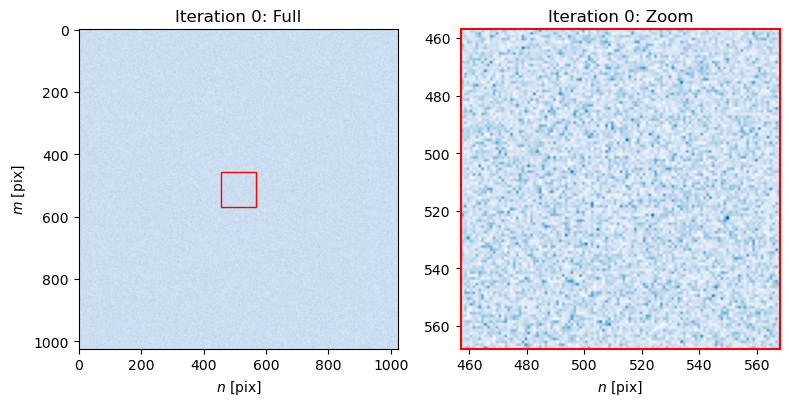

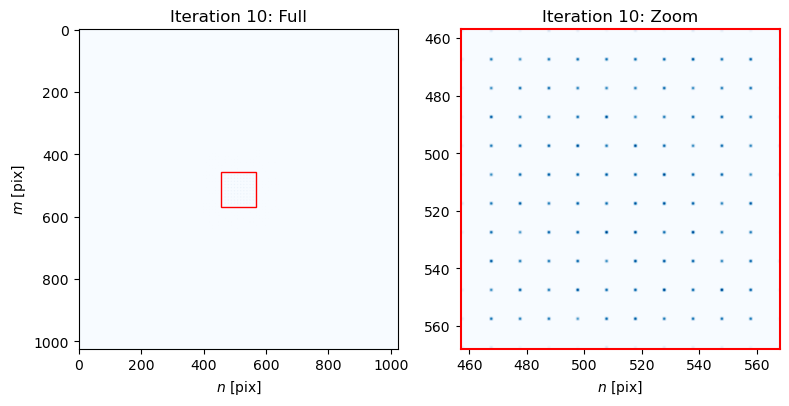

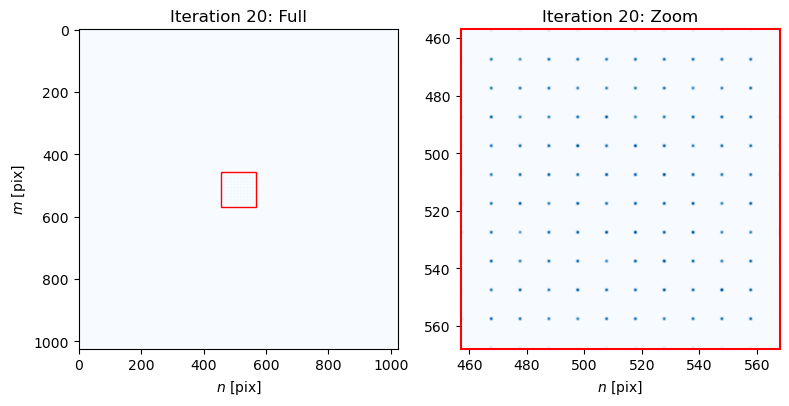

In [9]:
# Example callback function: plot the FF every 10 iterations
def plot_ff(holo):
    if holo.iter%10 == 0:
        holo.plot_farfield(limits=zoom, title='Iteration %d'%array_holo.iter)

# Now we'll run the computation using 21 iterations of GS.
array_holo.optimize(method="GS", maxiter=21, callback=plot_ff, 
                    stat_groups=['computational_spot'], verbose=False)

We see here that GS converges within a few steps to an image close to our target pattern. But how close? In the cell above, the addition of the ``stat_groups=['computational']`` parameter to the optimization loop had dual purpose: it 1) calculated statistics of the spot array uniformity and efficiency at each step of the GS optimization which 2) forced ``array_holo.amp_ff`` to be computed so that we could plot it with our callback function (for speed, ``amp_ff`` is not calculated at each optimization step unless needed). 

*Sidenote: statistics computation slows down GS (due to data transfer between ``numpy`` and ``cupy`` objects during each GS iteration) but has been heavily optimized to limit the performance loss.*

We can now plot the algorithm convergence (to see "how close" we got to the target) and the final near-field phase mask produced by the algorithm.

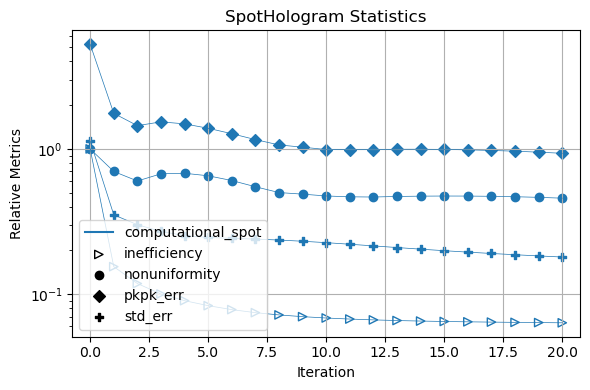

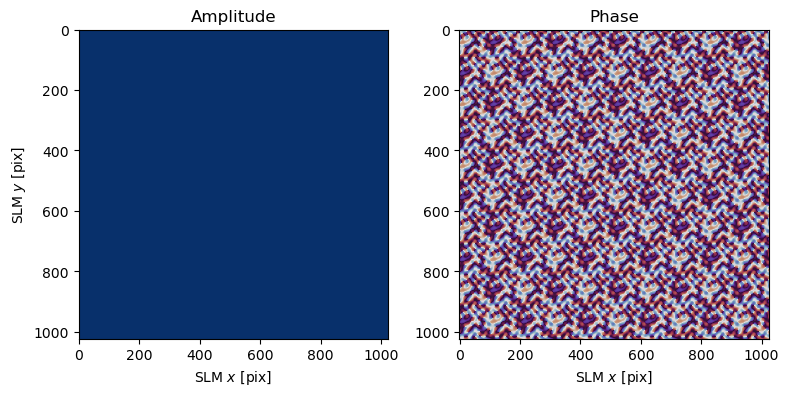

In [10]:
array_holo.plot_stats()
array_holo.plot_nearfield()

#### Comparing Algorithms

For the default GS algorithm, the inefficiency (fraction of power off-target), non-uniformity, and associated amplitude errors converge within a handfull of optimization iterations. The 50% resulting non-uniformity isn't stellar. Fortunately, a number of other "weighted" (i.e. "WGS") GS algorithms can improve these results. 

A complete listing of implemented algorithms can be found in the [``slmsuite`` documentation](https://slmsuite.readthedocs.io/en/latest/index.html). Here, we'll use a recently-developed [fixed-phase WGS algorithm](https://opg.optica.org/ol/abstract.cfm?uri=ol-44-12-3178). to compare to basic GS.

Optimizing with WGS-Kim using the following flags:
{'feedback': 'computational',
 'feedback_exponent': 0.9,
 'fix_phase_efficiency': None,
 'fix_phase_iteration': 5,
 'fixed_phase': False,
 'stat_groups': ['computational_spot']}


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 292.74it/s]


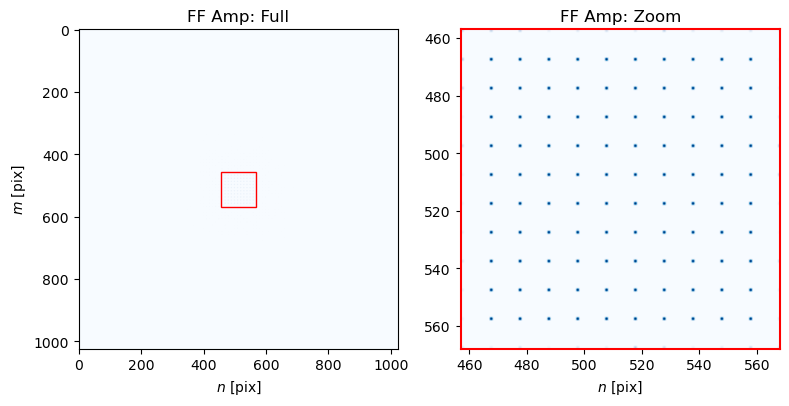

[(457, 568), (457, 568)]

In [11]:
# Retry with WGS using a fixed-phase algorithm
wgs_holo = SpotHologram.make_rectangular_array(slm_size,
    array_shape=(10,10), array_pitch=(10,10), basis='knm')
wgs_holo.optimize(method="WGS-Kim", maxiter=21, stat_groups=['computational_spot'])
wgs_holo.plot_farfield(limits=zoom)

Since we left out the ``verbose=False`` argument in the ``optimize`` call, we also see the flags being used by the optimization algorithm. Default values are assigned in ``slm-suite`` but you can pass any of these flags as an ``optimize`` argument to change the algorithm behavior (the ``stat_groups`` list is one example shown here). 

Let's now compare the results.

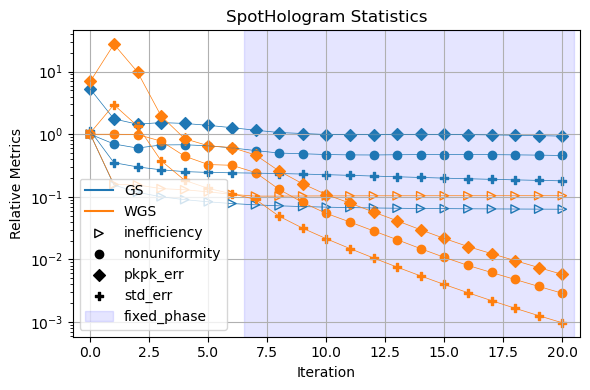

In [12]:
# Combine the statistics and compare
statscombined = wgs_holo.stats
statscombined["stats"]['WGS'] = statscombined["stats"].pop("computational_spot")
statscombined["stats"]["GS"] = array_holo.stats["stats"]["computational_spot"]

# (Optional) Reverse order to plot GS first
statscombined["stats"] = dict(reversed(statscombined["stats"].items()))

ax = wgs_holo.plot_stats(statscombined)

Much better: the WGS algorithm quickly converges once the far-field phase is fixed (defined here by the ``WGS-Kim`` algorithm's default ``fix_phase_iteration=5`` setting) at the cost of a slight efficiency reduction. 

#### Basic Image Formation

The same algorithms can be applied to more complex patterns, like pictures.

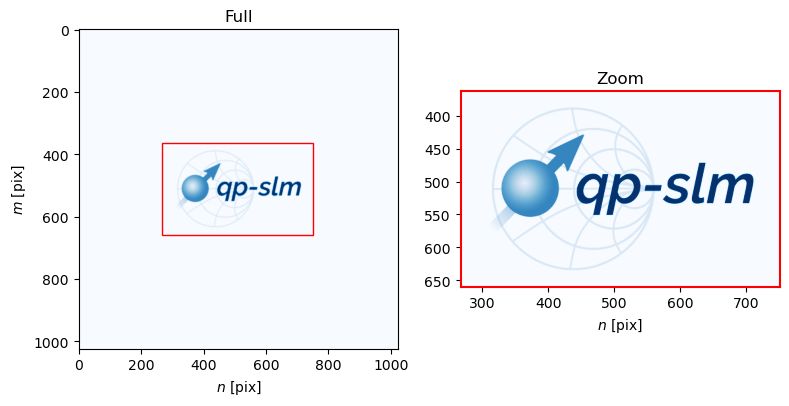

Optimizing with WGS-Kim using the following flags:
{'feedback': 'computational',
 'feedback_exponent': 0.9,
 'fix_phase_efficiency': None,
 'fix_phase_iteration': 5,
 'fixed_phase': False,
 'stat_groups': ['computational']}


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 46.93it/s]


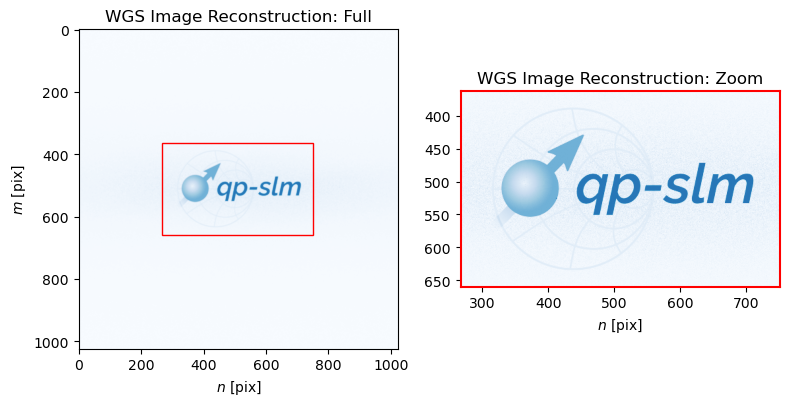

[(267, 752), (363, 660)]

In [15]:
import cv2

# Use a random logo
path = os.path.join(os.getcwd(), '../../slmsuite/docs/source/static/qp-slm-small.png')
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = cv2.bitwise_not(img) #Invert

# Resize (zero pad) for GS.
shape = (1024,1024)
target = toolbox.pad(img, shape)

holo = Hologram(target)
zoom = holo.plot_farfield(holo.target)

holo.optimize(method="WGS-Kim", maxiter=21)
holo.plot_farfield(limits=zoom,title='WGS Image Reconstruction')

We'll return to image formation in the experimental holography tutorial.

#### Furture Development

Notice that none of the examples in this notebook took more than 1 second to run: ``slmsuite`` is fast. In the future, we plan to add more algorithms (e.g. gradient descent-based amplitude and phase reconstructions) and full experimental simulation to assist in the development of new SLM algorithms and techniques. We hope that you'll join us! 